# Homotopic optimal control of inverted pendulum

## Dynamics

In [1]:
from sympy import *
init_printing()

In [2]:
# state variables
x, v, theta, omega = symbols("x v \\theta, \\omega", real=True)
s = Matrix([x, v, theta, omega])
s.T

[x  v  \theta  \omega]

In [3]:
# control parameter
u = symbols('u', real=True, nonzero=True)

# state equations of motion
ds = Matrix([v, u, omega, sin(theta) - u*cos(theta)])
ds

⎡             v              ⎤
⎢                            ⎥
⎢             u              ⎥
⎢                            ⎥
⎢           \omega           ⎥
⎢                            ⎥
⎣-u⋅cos(\theta) + sin(\theta)⎦

In [4]:
# homotopy parameters
alpha, beta = symbols('\\alpha \\beta', real=True, nonegative=True)

# homotopy between effort and time
L = beta + (1-beta)*abs(u)

# homotopy between energy and effort/time
L = alpha*L + (1-alpha)*u**2
L

In [5]:
# costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True, nonzero=True)
l.T

[\lambda_{x}  \lambda_{v}  \lambda_{\theta}  \lambda_{\omega}]

In [6]:
# Hamiltonian
H = l.dot(ds) + L
H

In [7]:
# costate equations of motion
dl = -H.diff(s)
dl

⎡                       0                       ⎤
⎢                                               ⎥
⎢                 -\lambda_{x}                  ⎥
⎢                                               ⎥
⎢-\lambda_{\omega}⋅(u⋅sin(\theta) + cos(\theta))⎥
⎢                                               ⎥
⎣               -\lambda_{\theta}               ⎦

In [8]:
# optimal control; note that alpha dissappears
# because effort and time optimality are equivalent in this case
us = solve(H.diff(u), u)[0]
us.subs(alpha, 1)

In [9]:
# effort/time optimal control (bang-bang)
ul = us.subs(alpha, 0)
ul

In [ ]:
print(latex(ul))

## Base trajectory
We first solve for a base trajectory, which will subsequently be used to iniate the forthcoming homotopy sequence approach to reaching the difficultly found bang-bang optimal control.

In [10]:
import sys, numpy as np, matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sys.path.append('../src/')
from pendulum import Pendulum
%matplotlib inline

In [11]:
# instantiate problem
seg = Pendulum()

# solve arguments
s0 = [0,0,np.pi,0]
alpha = 0
Tlb = 5
Tub = 15
lb = 1

In [12]:
# solve
zg = None
zg = [10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696]
#zg = [6.12032571, 0.03676911, 0.90012948, 1.40507211, 0.39248787]
while True:
    z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)
    if feas:
        break
z

array([10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696])

In [13]:
# simulate the solution's resultant trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[1:], alpha, atol=1e-12, rtol=1e-12, u=True)

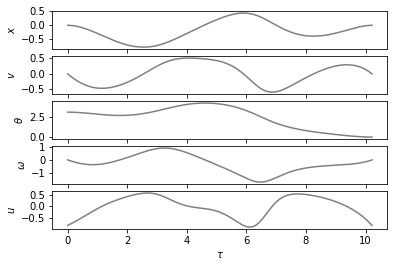

In [14]:
# plot states and control
fig, ax = seg.plot_states(tl, sl, ul)

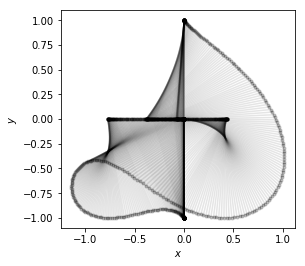

In [15]:
# plot geometric trajectory
fig, ax = seg.plot_traj(tl, sl)

## Policy homotopy

```python
zo = None
a = 0
while a < 1:
    z = solve(zo, a)
    if succesfull(z):
        zo = z
        a = increase(a)
    else:
        a = decrease(a)
```

## Forward homotopy $\alpha: 0 \rightarrow 1$
This brings us to a bang-bang policy with an appropriate magnitude, which is realisable from the original quadratic policy.

In [16]:
#sols = seg.homotopy(s0, 0, Tlb, Tub, 10, z, 1, step=0.001)
sols = np.load("ph.npy")

In [17]:
#np.save('ph.npy', np.flip(sols, axis=0))

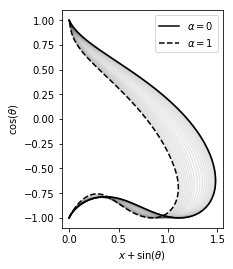

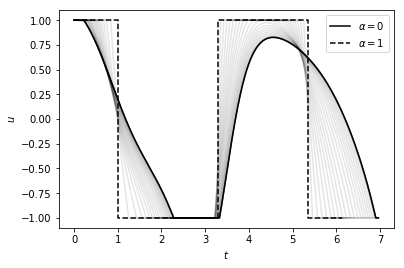

In [20]:
# plot the forward homotopy 
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
for i in range(len(sols)):
    z = sols[i][0]
    a = sols[i][1]
    seg.alpha = a
    tl, sl, ul = seg.propagate(z[0], s0, z[1:], a, u=True)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    if a == 0:
        ax.plot(x, y, "k-", alpha=1, label=r"$\alpha=0$")
        ax1.plot(tl, ul, "k-", alpha=1, label=r"$\alpha=0$")
    elif a == 1:
        ax.plot(x, y, "k--", alpha=1, label=r"$\alpha=1$")
        ax1.plot(tl, ul, "k--", alpha=1, label=r"$\alpha=1$")
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
ax.legend()
ax1.legend()
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$u$')
plt.show()
fig.savefig("phs.pdf", bbox_inches='tight')
fig1.savefig("phu.pdf", bbox_inches='tight')

## Random walks

```python
T = []
so = snom
zo = znom
while len(T) < N:
    s = perturb(so, ds)
    z = solve(s, zo)
    if succesfull(z):
        so = s
        zo = z
        T.append((so, zo))
        ds = increase(ds)
    else:
        ds = decrease(ds)
        
```

In [21]:
sols[0]

array([array([ 6.96209275,  0.33095384,  0.29435989, -1.11307474, -2.53239123]),
       0], dtype=object)

In [22]:
# arguments
so = s0
zo = zg
zo = sols[0][0]
alpha = 0
n = 1
Tlb = 0
Tub = 15
lb = 5
nw = 8

# random walks
#T = seg.random_walk_par(so, zo, alpha, n, Tlb, Tub, lb, nw, dsm=0.02, verbose=True)
T = np.load('pqdb.npy')

In [23]:
#np.save('pqdb.npy', T)

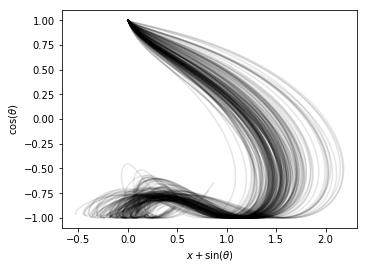

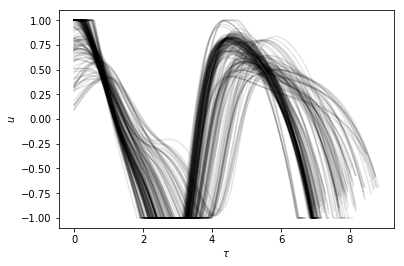

In [24]:
# plot the random walks
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

# for each random walk
first = False
for t in T:
    
    # initial state
    s0 = t[0]
    
    # decision vector
    z = t[1]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if first:
        ax.plot(x, y, "k-", alpha=1, label="Nominal")
        ax1.plot(tl, ul, "k-", alpha=1, label="Nominal")
        first = False
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
#ax.legend()
#ax1.legend()
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()
#fig.savefig('pqdbs.pdf', bbox_inches='tight')
#fig1.savefig('pqdbu.pdf', bbox_inches='tight')

## Database homotopy

In [25]:
#res = seg.homotopy_db(T, 0, 0, 15, 5, 1, step=0.01)
res = np.load('pqhdb.npy')

In [26]:
#np.save('pqhdb.npy', res)

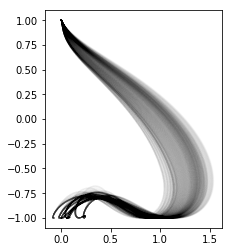

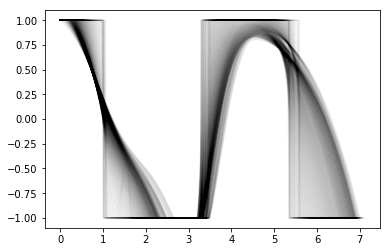

In [27]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

for r in res:
    
    # initial state
    s0 = r[0]
    
    # decision vector
    z = r[1]
    
    # homotopy parameter
    alpha = r[2]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if alpha > 1.2:
        ax.plot(x, y, "k--", alpha=1)
        ax1.plot(tl, ul, "k--", alpha=1)
    else:
        ax.plot(x, y, "k-", alpha=0.01)
        ax1.plot(tl, ul, "k-", alpha=0.01)
ax.set_aspect('equal')
    
plt.show()    
#fig1.savefig('phdbu.pdf')

# Training a neural network

In [28]:
from ann import *

In [29]:
# generate the databases
#data = seg.gen_db(res, cat=True)
data = np.load('pqhanndb.npy')

In [35]:
len(data)

In [30]:
# save the database
#np.save('pqhanndb.npy', data)

In [31]:
# format the data for the ann
db = Data(data, [0, 1, 2, 3, 4], [5])

In [32]:
# instantiate the neural network
mlp = Pendulum_Controller([5, 20, 20, 1])

In [ ]:
mlp.train(db.i, db.o, epo=2000, lr=1e-3, gpu=False, ptst=0.1)

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(mlp.ltrn, "k-")
ax.plot(mlp.ltst, "k--")
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [ ]:
mlp.cpu()

## Simulating the neural network controller

In [ ]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
s0 = np.array([0, 0, np.pi, 0])
n = 10
for alpha, alphac in zip(np.linspace(0, 1, n), np.linspace(0.2, 0.8, n)):
    T = 6.5
    tl, sl, ul = seg.propagate_controller(T, s0, mlp.predict, alpha, atol=1e-13, rtol=1e-13)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    ax.plot(x, y, "k-", alpha=alphac)
    ax1.plot(tl, ul, "k-", alpha=alphac)
ax.set_aspect('equal')
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()

## Neural network accuracy

In [ ]:
n = 2

fig, ax = plt.subplots(n, sharex=True)
s = np.array([0, 0, np.pi, 0])
il = np.linspace(0, len(sols)-1, n, dtype=int)
for i, j in zip(il, range(n)):
    
    # simulate
    z = sols[i][0]
    alpha = sols[i][1]
    tl, sl, ul = seg.propagate(z[0], s, z[1:], alpha, u=True)
    tst = torch.tensor(np.hstack((sl[:, :seg.sdim], np.full((len(sl), 1), alpha))))
    tst = mlp(tst).detach().numpy().flatten()
    ax[j].plot(tl, ul, "k--")
    ax[j].plot(tl, tst, "k-", alpha=0.5)
    ax[j].set_title(r'$\alpha = {:.0f}$'.format(alpha))
    ax[j].set_ylabel(r'$u$')
    
ax[-1].set_xlabel(r'$\tau$')
ax[-1].legend(['Ground truth', 'Prediction'])
    
plt.tight_layout()
plt.show()
fig.savefig('punn.pdf', bbox_inches='tight')